# Project #4：SSB Modulation and Demodulation

Consider two information signals, one a time-domain rectangular pulse and the other a timedomain triangular pulse. Choose the duration and amplitude of each pulse as you wish.
Design and implement a SSB modulator/demodulator to transmit/recover these pulses such that one signal is assigned to the USB while the other is assigned to the LSB. The SSB signal
is assumed to be transmitted through a noise-free and distortion-free channel. The modulator is shown in iamge. The demodulator should use the coherent detection method.




(Due Date: 23/11/2023, class time)

Jie Wang

Junhao Zhu


![image](generation_ssb.png)

## Project requirements: 

Implement both the modulator and demodulator using Python and plot all relevant signals in both time and frequency domain. You should verify that your system is working by exhibiting two reconstructed rectangular and triangular pulses at the demodulator’s outputs. 

Provide also sketches or spectra and all relevant mathematical details explaining how your design works. 


No need to rederive SSB modulation/demodulation as you did in the homework, only provide information needed for this purpose of this project.


![image](demodulation_ssb.png)

## Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert

# Define the message signals
# def rect_pulse(t, duration, amplitude):
#     return amplitude * (np.abs(t) < duration / 2)

def tri_pulse(t, T0, amplitude=1.0):
    return np.where((t >= -T0/2) & (t <= T0/2), amplitude * (1 -(2/T0)*np.abs(t)), 0)


# def tri_pulse(t, duration, amplitude):
#     return amplitude * (np.maximum(0, 1 - np.abs(t) / duration))


# generate pulse in (T1,T1+dt) with amplitude
def rect_pulse(t,T1,dt,amplitude = 1.0):
    return np.where((t >= T1-dt) & (t <= T1+dt), amplitude, 0)


# Define the carrier signal
def carrier_signal(t, Ac, fc):
    return Ac * np.cos(2 * np.pi * fc * t)

# parameter setting
fs = 500
t = np.linspace(-100, 100, 200*fs)  # Time vector
Ac = 1
fc = 100  # Carrier frequency
tri_pulse_signal = tri_pulse(t, 0.1, 2)
rect_pulse_signal = rect_pulse(t, 0.05, 1)



### high pass filter selection
We have tried using `scipy.signal.lfilter` to demodulate the SSB signal. However, we find it very hard to obtain the original rectangular signal, the distortion is very severe. 

We think it might be because of the **Filter Edges**: If the band-pass filter has very sharp cutoff edges or a non-linear phase response, it can introduce ringing artifacts due to the Gibbs phenomenon. Although we can use a filter with smoother transition bands and a linear phase response to minimize distortion, we decide to use ideal HPF as following:



In [12]:
import numpy as np

def generate_hpf(f, fc, f_low, f_high):
    """
    Generates a frequency mask for selecting specific frequency components.

    Parameters:
    f (array): Frequency array.
    fc (float): Center frequency.
    f_low (float): Lower frequency bound.
    f_high (float): Upper frequency bound.

    Returns:
    array: A boolean mask for the frequency array.
    """

    # Create a mask for positive frequency range
    positive_mask = np.logical_and(f >= f_low, f <= f_high)
    negative_mask = np.logical_and(f >= -f_high, f <= -f_low)
    bpf_mask      = np.logical_or(positive_mask,negative_mask)
    if fc == 0:
        return positive_mask
    else:
        return bpf_mask


### Bandwidth Computation
To compute the bandwidth of message signal, it is hard to use Carson's rule when the frequency of message signal and carrier signal is relative close. 
Therefore, we choose to directly computate the 99.9% of message energy. 

In [13]:
def cal_bandwidth(amp,f,fc):
    j = 0
    maximum = 0
    for j in range(len(f)):
        if amp[j]>maximum:
            maximum = amp[j]
    print(maximum)
    i = 0
    if (fc > 0):
        while amp[i]<=0.001*maximum:
            i += 1
        bw = 2*(fc-f[i])
    if (fc == 0):
        while amp[i]>0.001*maximum:
            i += 1
        result = 2*(f[i]-fc)
    return bw


## modulation

In [14]:

# # SSB Modulator
# def ssb_modulate(t, m_t, Ac, fc, usb=True):
#     # Perform modulation
#     modcos = m_t * np.cos(2*np.pi*fc*t)
#     modsin = hilbert(m_t) * np.sin(2*np.pi*fc*t)
#     # Extract the analytic signal (Hilbert transform)
#     if usb:
#         return modcos + modsin
#     else:
#         return modcos - modsin

def ssb_modulate(t,m_t,Ac,fc,usb=True):
    fs = 500
    modulated_signal = m_t * np.cos(2*np.pi*fc*t)
    f = np.fft.fftfreq(len(modulated_signal), fs)
    M_f = np.fft.fft(modulated_signal) / fs
    bandwidth = cal_bandwidth(abs(M_f),f,fc) # 参数是amp而非X

    if usb:
        mask = generate_hpf(f,fc,fc, fc+ bandwidth/2)
    else:
        mask = generate_hpf(f,fc,fc- bandwidth/2, fc)

    SSB_signal = np.fft.ifft(M_f * mask) *2*fs 

    return np.real(SSB_signal)

# Modulate the signals
ssb_tri = ssb_modulate(t, tri_pulse_signal, Ac, fc, usb=False)
ssb_rect = ssb_modulate(t, rect_pulse_signal, Ac, fc, usb=True)


0.049999499577505116
1.0000000266915074


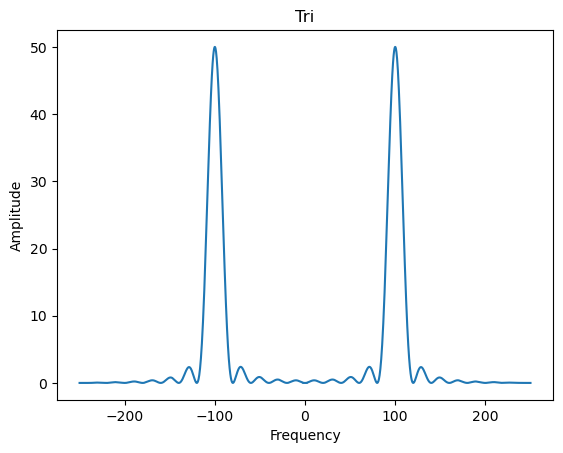

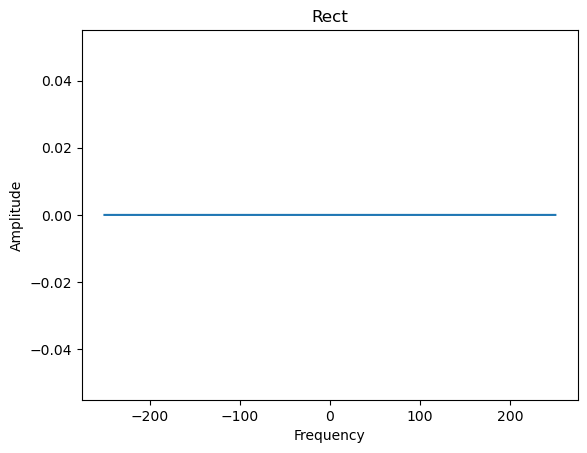

In [15]:


def plot_spectrum(t, signal,title):
    # Compute the Fourier Transform of the signal
    spectrum = np.fft.fft(signal)
    # Shift the zero frequency component to the center of the spectrum
    shifted_spectrum = np.fft.fftshift(spectrum)
    # Generate frequency axis that is centered around zero
    freq = np.fft.fftfreq(t.shape[-1], d=(t[0] - t[1]))
    # Shift the frequency axis
    shifted_freq = np.fft.fftshift(freq)
    
    # Plotting
    plt.figure()
    plt.title(title)
    # plt.plot(shifted_freq, np.abs(spectrum))
    plt.plot(shifted_freq, np.abs(shifted_spectrum))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()


# Use the combined_ssb_modulate function
plot_spectrum(t, ssb_tri,'Tri')
plot_spectrum(t, ssb_rect,'Rect')



In [16]:
def ssb_demodulate(t, s_t, Ac, fc, usb=True):
    # Perform coherent detection
    coherent_detector_output = s_t * carrier_signal(t, Ac, fc)
    # Low-pass filter to retrieve the baseband signal
    # Define a low-pass filter
    b, a = butter(5, 0.1)
    # Filter the signal
    return lfilter(b, a, coherent_detector_output)

# Demodulate the signals
demod_rect = ssb_demodulate(t, ssb_rect, Ac, fc, usb=True)
demod_tri = ssb_demodulate(t, ssb_tri, Ac, fc, usb=False)



The `ssb_modulate` and `ssb_demodulate` functions are simplified and would need to be fleshed out with appropriate filtering. Note that the Hilbert transform in `ssb_modulate` is a simplified approach to generating the SSB signal and may not perfectly isolate the USB or LSB. In practice, you would use a band-pass filter designed to pass only the desired sideband.

Remember, this is a high-level overview, and each function must be carefully designed and implemented according to the signal processing requirements of SSB modulation and demodulation.

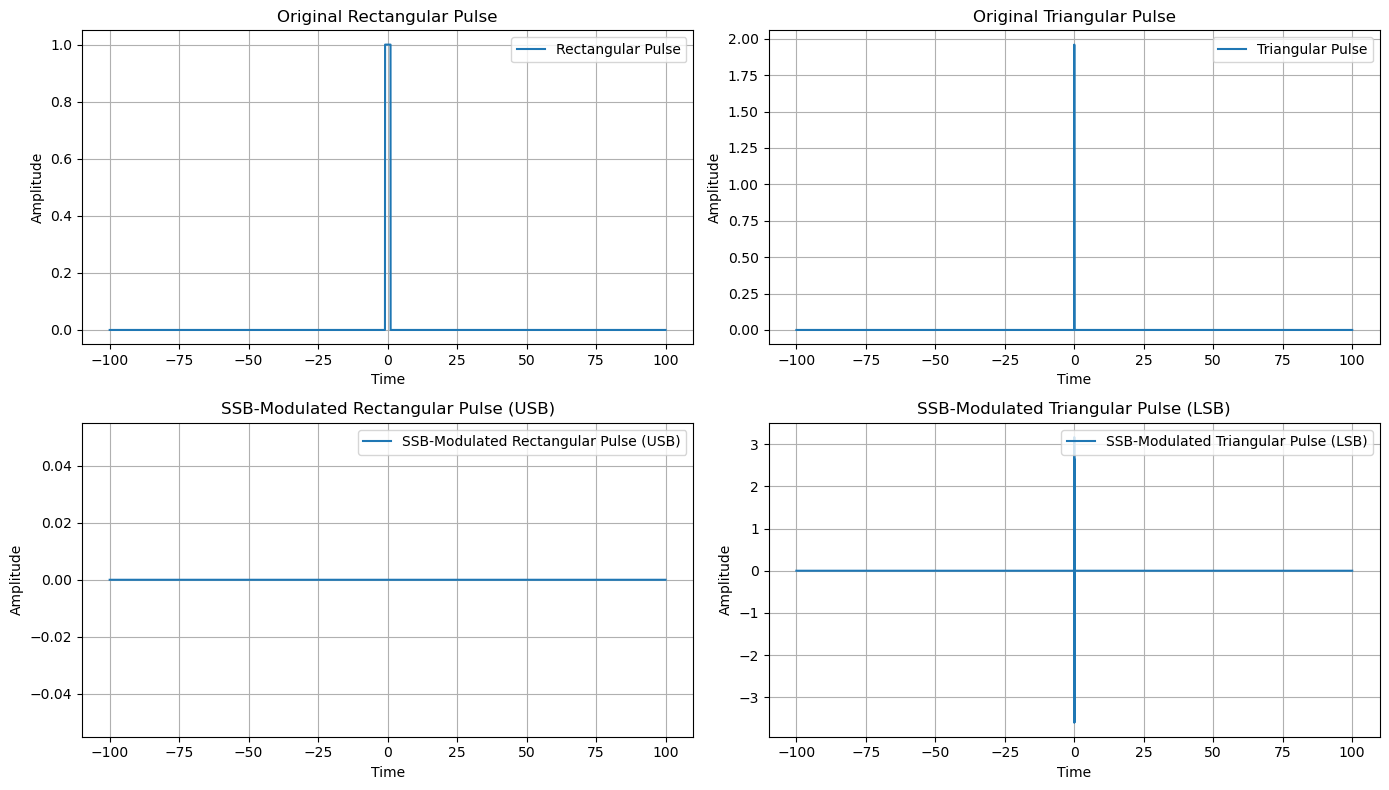

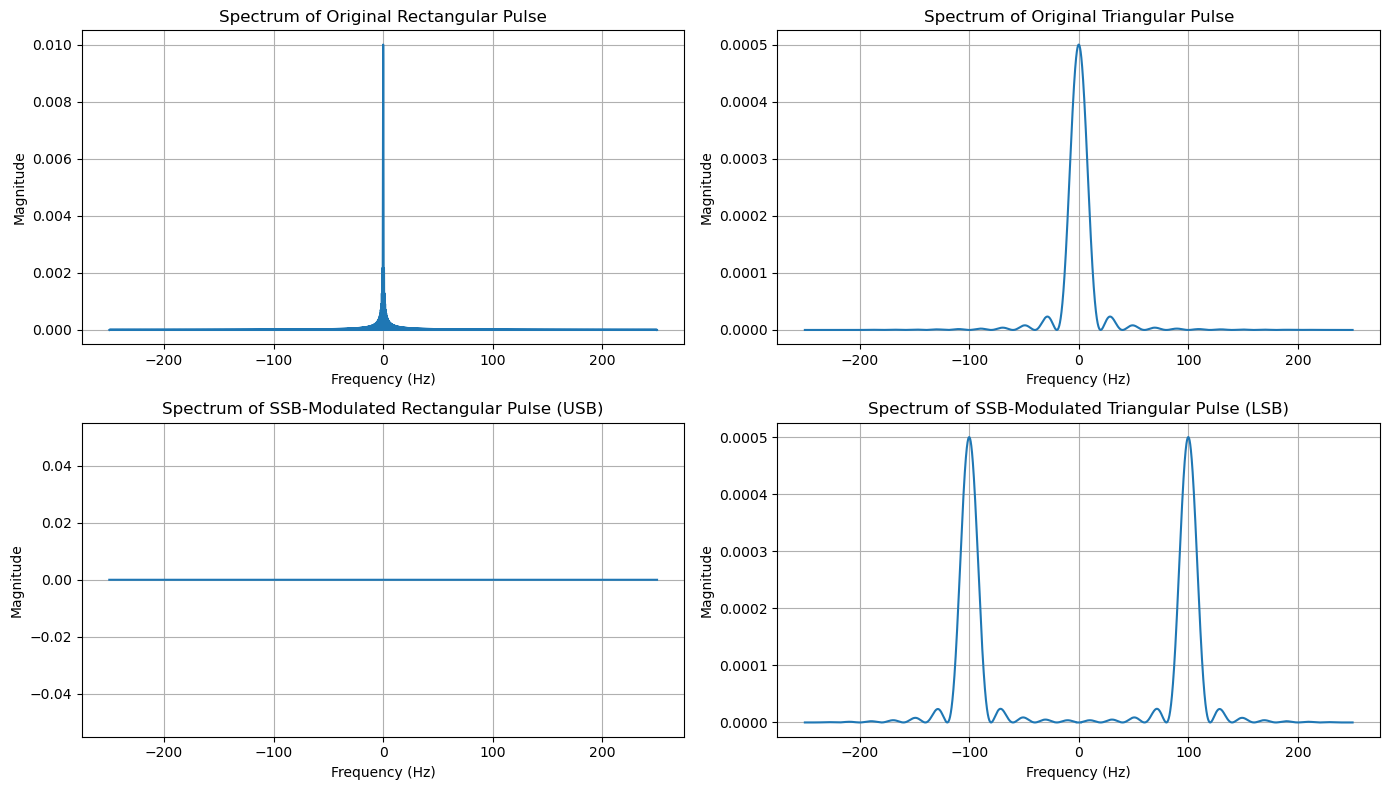

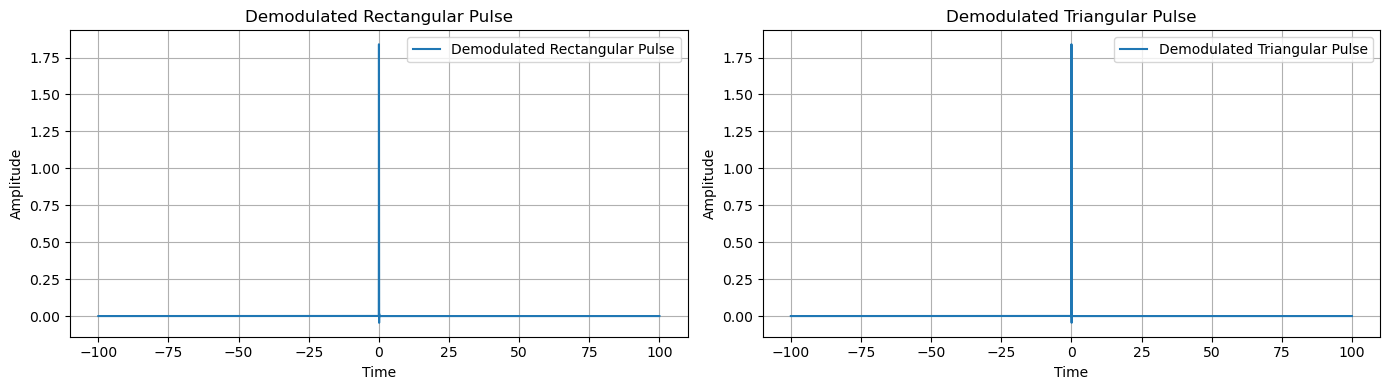

In [17]:
# Plotting in Time Domain
plt.figure(figsize=(14, 8))

# Plot the original message signals
plt.subplot(2, 2, 1)
plt.plot(t, rect_pulse_signal, label='Rectangular Pulse')
plt.title('Original Rectangular Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t, tri_pulse_signal, label='Triangular Pulse')
plt.title('Original Triangular Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot the SSB-modulated signals
plt.subplot(2, 2, 3)
plt.plot(t, ssb_rect, label='SSB-Modulated Rectangular Pulse (USB)')
plt.title('SSB-Modulated Rectangular Pulse (USB)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t, ssb_tri, label='SSB-Modulated Triangular Pulse (LSB)')
plt.title('SSB-Modulated Triangular Pulse (LSB)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting in Frequency Domain
from scipy.fft import fft, fftshift, fftfreq

# Calculate the FFT and frequencies for plotting
def plot_spectrum(signal, t, title):
    N = len(t)
    T = t[1] - t[0]  # Sample spacing
    yf = fft(signal)
    xf = fftfreq(N, T)
    xf = fftshift(xf)
    yplot = fftshift(yf)
    
    plt.plot(xf, 1.0/N * np.abs(yplot))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

plt.figure(figsize=(14, 8))

# Plot the frequency spectrum of the original message signals
plt.subplot(2, 2, 1)
plot_spectrum(rect_pulse_signal, t, 'Spectrum of Original Rectangular Pulse')

plt.subplot(2, 2, 2)
plot_spectrum(tri_pulse_signal, t, 'Spectrum of Original Triangular Pulse')

# Plot the frequency spectrum of the SSB-modulated signals
plt.subplot(2, 2, 3)
plot_spectrum(ssb_rect, t, 'Spectrum of SSB-Modulated Rectangular Pulse (USB)')

plt.subplot(2, 2, 4)
plot_spectrum(ssb_tri, t, 'Spectrum of SSB-Modulated Triangular Pulse (LSB)')

plt.tight_layout()
plt.show()

# Plotting the demodulated signals in Time Domain
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(t, demod_rect + demod_tri, label='Demodulated Rectangular Pulse')
plt.title('Demodulated Rectangular Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, demod_tri, label='Demodulated Triangular Pulse')
plt.title('Demodulated Triangular Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
